In [35]:
import numpy as np
import pandas as pd 
import fbprophet 
from fbprophet import Prophet
import plotly
import statsmodels
from statsmodels.tsa.stattools import acf
from matplotlib import pyplot
import altair as alt
import scipy
from scipy import signal
import spectrum 
from spectrum import WelchPeriodogram
from spectrum import Periodogram
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import q_stat
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_process import arma_generate_sample
from statsmodels.tsa.stattools import arma_order_select_ic
import statsmodels.api as sm
from math import sqrt
import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

In [2]:
flu_data = pd.read_csv('flu.csv', header = 2, sep = ',')

In [3]:
flu_data.head(n=5)

,Country,WHOREGION,FLUREGION,Year,Week,SDATE,EDATE,SPEC_RECEIVED_NB,SPEC_PROCESSED_NB,AH1,...,AH5,ANOTSUBTYPED,INF_A,BYAMAGATA,BVICTORIA,BNOTDETERMINED,INF_B,ALL_INF,ALL_INF2,TITLE
0,United States of America,Region of the Americas of WHO,North America,2013,1,2012-12-31,2013-01-06,18219,18219,0.0,...,0.0,1653,5377,0,0,1097,1097,6474,NaN,Widespread Outbreak
1,United States of America,Region of the Americas of WHO,North America,2013,2,2013-01-07,2013-01-13,20013,20013,0.0,...,0.0,1767,5752,0,0,1145,1145,6897,NaN,Widespread Outbreak
2,United States of America,Region of the Americas of WHO,North America,2013,3,2013-01-14,2013-01-20,19228,19228,0.0,...,0.0,1624,4858,0,0,1078,1078,5936,NaN,Widespread Outbreak
3,United States of America,Region of the Americas of WHO,North America,2013,4,2013-01-21,2013-01-27,17139,17139,0.0,...,0.0,1528,4039,0,0,1091,1091,5130,NaN,Widespread Outbreak
4,United States of America,Region of the Americas of WHO,North America,2013,5,2013-01-28,2013-02-03,14795,14795,0.0,...,0.0,951,2963,0,0,1076,1076,4039,NaN,Widespread Outbreak


## Utility Functions

In [4]:
def arima_window_ase(data_series, train_ratio = .60, order = (0,0,0)): 
    X_series = data_series.values
    size = int(len(X_series)*train_ratio)
    train,test = X_series[0:size], X_series[size:len(X_series)]
    history = [i for i in train]
    preds = list()
    for t in range(len(test)): 
        model = ARIMA(history, order=order)
        model_fit = model.fit()
        fore_cast = model_fit.forecast()
        yhat = fore_cast[0]
        preds.append(yhat)
        obs = test[t]
        history.append(obs)
    rmse = sqrt(mean_squared_error(test, preds))
    pyplot.plot(test)
    pyplot.plot(preds, color='red')
    pyplot.show()
    
    return rmse
    print(residuals.describe())

In [5]:
def make_realization(data_frame,x,y): 
    
    vis = alt.Chart(data_frame).mark_line().encode(
    x = x, 
    y = y
    )
    
    return vis

In [6]:
def make_autocorr(data_series, nlags=40, fft = False): 
    auto_corr = statsmodels.tsa.stattools.acf(data_series, nlags=nlags, fft=fft)
    data = pd.DataFrame(list(enumerate(auto_corr)), columns = ['Lag', 'AutoCor'])
    vis = alt.Chart(data).mark_bar().encode(
    x='Lag',
    y='AutoCor',
    )
    return vis

In [7]:
def make_sig_periodgram(data_series, fs = 1, scaling = 'density'): 
    f, Pxx_den = scipy.signal.periodogram(data_series, fs = fs, scaling=scaling)
    data = pd.DataFrame({'Freq' : f,'Density' : Pxx_den})
    vis = alt.Chart(data).mark_bar().encode(
        x='Freq',
        y='Density',
    )
    return vis

In [8]:
def make_welch_sig_periodgram(data_series, fs = 1, nperseg=50): 
    f, Pxx_den = scipy.signal.welch(flu_data.SPEC_RECEIVED_NB, fs = 1, nperseg=nperseg)
    data = pd.DataFrame({'Freq' : f,'Density' : Pxx_den})
    vis = alt.Chart(data).mark_bar().encode(
        x='Freq',
        y='Density',
    )
    return vis

In [9]:
def make_welch_periodgram(data_series, sampling = 50):
    psd = WelchPeriodogram(data_series, sampling)
    return psd[1]

### Function call to realization generations

In [10]:
make_realization(flu_data, 'EDATE:T', 'SPEC_RECEIVED_NB')

alt.Chart(...)

### Under the hood this is what the make_realization function does

In [11]:
alt.Chart(flu_data).mark_line().encode(
    x='EDATE:T',
    y='SPEC_RECEIVED_NB'
)


alt.Chart(...)

### To verify if variable is a series 

In [12]:
series = flu_data.SPEC_RECEIVED_NB
series.index

RangeIndex(start=0, stop=423, step=1)

### Function call to generate autocorrelation plot
### we can see there is evidence against stationarity, there is slowly dampening sinusiodal autocorrelations

In [13]:
make_autocorr(flu_data.SPEC_RECEIVED_NB, nlags = 40)

alt.Chart(...)

### Under the hood this is what the make_autocorr function does

In [14]:
SPEC_RECIEVD_NB_auto_cor = statsmodels.tsa.stattools.acf(flu_data.SPEC_RECEIVED_NB)

/home/andrew/Documents/qtw/env/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:662: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  FutureWarning,
/home/andrew/Documents/qtw/env/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:671: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning,


In [15]:
data = pd.DataFrame(list(enumerate(SPEC_RECIEVD_NB_auto_cor)), columns = ['Lag', 'AutoCor'])
alt.Chart(data).mark_bar().encode(
    x='Lag',
    y='AutoCor',
)

alt.Chart(...)

### Make function call to series periodgram to see if underlying frequency exists

In [16]:
make_sig_periodgram(flu_data.SPEC_RECEIVED_NB)

alt.Chart(...)

### ### Under the hood this is what the make_sig_periodgram function does

In [17]:
f, Pxx_den = scipy.signal.periodogram(flu_data.SPEC_RECEIVED_NB, fs = 1, scaling='density')

In [18]:
data = pd.DataFrame({'Freq' : f,'Density' : Pxx_den})
alt.Chart(data).mark_bar().encode(
    x='Freq',
    y='Density',
)

alt.Chart(...)

### make function call to make_welch_sig_perdiogram function

In [19]:
make_welch_sig_periodgram(flu_data.SPEC_RECEIVED_NB, fs = 1, nperseg=420)

alt.Chart(...)

### Under the hood this is what the make_realization function does

In [20]:
f, Pxx_den = scipy.signal.welch(flu_data.SPEC_RECEIVED_NB, fs = 1, nperseg=420)

In [21]:
data = pd.DataFrame({'Freq' : f,'Density' : Pxx_den})
alt.Chart(data).mark_bar().encode(
    x='Freq',
    y='Density',
)

alt.Chart(...)

### function call to welch Power Spectral Density plot function 

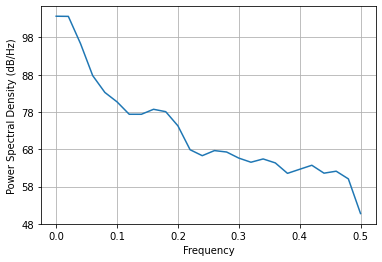

In [22]:
make_welch_periodgram(flu_data.SPEC_RECEIVED_NB,sampling = 50)

### Under the hood this is what the make_welch_periodgram function does

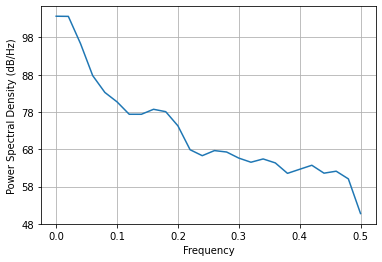

In [23]:
psd = WelchPeriodogram(flu_data.SPEC_RECEIVED_NB,50)

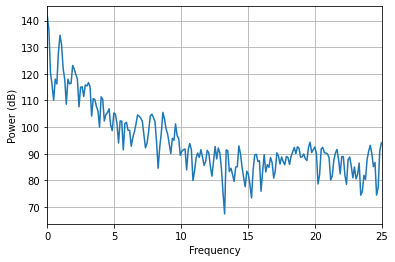

In [24]:
psd = Periodogram(flu_data.SPEC_RECEIVED_NB, 50, scale_by_freq = True)
psd.plot()

### Lets get an estimate of our arma model structure, assuming stationarity despite evidence against

In [25]:
res = statsmodels.tsa.stattools.arma_order_select_ic(flu_data.SPEC_RECEIVED_NB, ic=["aic", "bic"], trend="nc")

/home/andrew/Documents/qtw/env/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/home/andrew/Documents/qtw/env/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA an

In [26]:
res.aic

,0,1,2
0,NaN,9340.380969,8935.618407
1,8137.488407,8028.267909,7989.563702
2,7985.137073,7986.159993,7984.675115
3,7986.216854,7983.348112,7984.749204
4,7988.216563,7984.104760,7971.680217


In [27]:
res.aic_min_order

(4, 2)

In [28]:
res.bic

,0,1,2
0,NaN,9348.475713,8947.760524
1,8145.583151,8040.410025,8005.753190
2,7997.279190,8002.349482,8004.911976
3,8002.406343,8003.584973,8009.033437
4,8008.453424,8008.388994,8000.011822


In [29]:
res.bic_min_order

(2, 0)

### AIC and BIC differ, but we will go with BIC model structure, suggesting the errors are Gaussian, but maylook to be centered on zero. We see the errors still look correlated and there is some trend the model is not capturing. 

                               SARIMAX Results                                
Dep. Variable:       SPEC_RECEIVED_NB   No. Observations:                  423
Model:                 ARIMA(2, 0, 0)   Log Likelihood               -3985.131
Date:                Fri, 19 Feb 2021   AIC                           7978.263
Time:                        15:51:33   BIC                           7994.452
Sample:                             0   HQIC                          7984.660
                                - 423                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.131e+04   8613.545      2.474      0.013    4428.421    3.82e+04
ar.L1          1.5316      0.024     65.133      0.000       1.485       1.578
ar.L2         -0.5602      0.022    -25.103      0.0

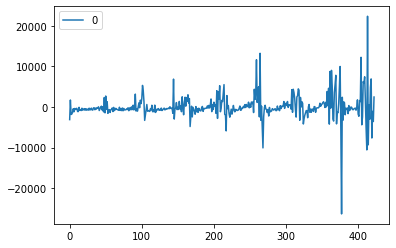

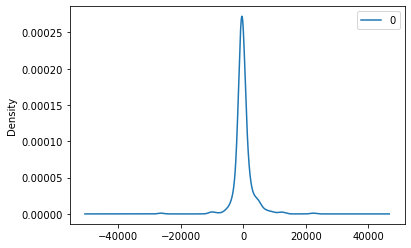

                  0
count    423.000000
mean      11.453362
std     2980.691003
min   -26331.120360
25%     -861.404582
50%     -356.491900
75%      489.911810
max    22381.314924


In [30]:
model = ARIMA(flu_data.SPEC_RECEIVED_NB, order=(2,0,0))
model_fit = model.fit()
# summary of fit model
print(model_fit.summary())
# line plot of residuals
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
pyplot.show()
# density plot of residuals
residuals.plot(kind='kde')
pyplot.show()
# summary stats of residuals
print(residuals.describe())

### Function call to arima_window_ase
### We can see the model does follow the data well. 

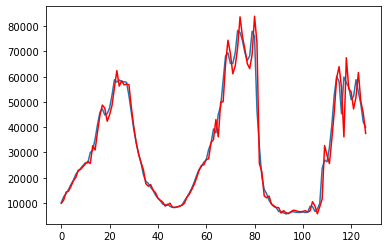

4705.919487486771

In [31]:
arima_window_ase(flu_data.SPEC_RECEIVED_NB, train_ratio = .70, order=(2,0,0))

### Under the hood this is what the arima_window_ASE does 

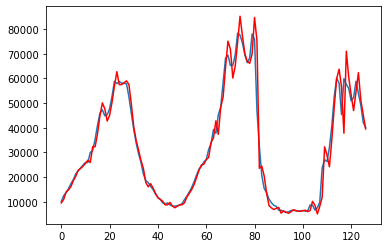

In [32]:
X = flu_data.SPEC_RECEIVED_NB.values
size = int(len(X) * 0.70)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
# window MSE 
for t in range(len(test)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
# evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

In [33]:
rmse

4789.260997720546

In [53]:
m = Prophet()
Prophet_df = flu_data[['EDATE','SPEC_RECEIVED_NB']].copy()
Prophet_df['EDATE'] = Prophet_df['EDATE'].astype('datetime64[ns]')
Prophet_df.columns = ['ds', 'y']
Prophet_df.info()
m.fit(Prophet_df)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 423 entries, 0 to 422
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      423 non-null    datetime64[ns]
 1   y       423 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 6.7 KB


In [54]:
future = m.make_future_dataframe(periods=50)
future.tail()

,ds
468,2021-03-25
469,2021-03-26
470,2021-03-27
471,2021-03-28
472,2021-03-29


In [55]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
468,2021-03-25,47312.797090,34889.126938,58791.871616
469,2021-03-26,46713.763190,33904.945778,58140.416972
470,2021-03-27,46086.452479,33979.666590,58928.037238
471,2021-03-28,45434.216927,34006.908337,57990.017947
472,2021-03-29,44760.846220,32581.601651,56459.149565
